# CNN and MLP Models: CIFAR-10 Datasets

Muhammad Aizar Yazid 1103223097

# Import Libraries

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [14]:
# Set device untuk PyTorch (GPU jika tersedia di Colab)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Data Preparation

In [15]:
# Transformasi untuk dataset CIFAR-10 (PyTorch)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset untuk PyTorch (CNN)
trainset_torch = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset_torch = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader_torch = DataLoader(trainset_torch, batch_size=64, shuffle=True)
testloader_torch = DataLoader(testset_torch, batch_size=64, shuffle=False)

# Load CIFAR-10 dataset untuk TensorFlow (MLP)
(trainset_tf, testset_tf), ds_info = tfds.load('cifar10', split=['train', 'test'], as_supervised=True, with_info=True)
def preprocess_tf(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalisasi
    return image, label

trainset_tf = trainset_tf.map(preprocess_tf).shuffle(10000).batch(64)
testset_tf = testset_tf.map(preprocess_tf).batch(64)

# Defining CNN model and training (PyTorch)

In [16]:
# Definisi model CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)  # Input: 3 channels (RGB), Output: 32 filters
        self.pool = nn.MaxPool2d(2, 2)    # Pooling 2x2
        self.conv2 = nn.Conv2d(32, 64, 3) # Input: 32, Output: 64
        self.fc1 = nn.Linear(64 * 6 * 6, 128)  # Fully connected layer
        self.fc2 = nn.Linear(128, 10)     # Output: 10 kelas

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 6 * 6)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Inisialisasi model, loss, dan optimizer
cnn_model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

In [17]:
# Training CNN (PyTorch)
def train_cnn(epochs=10):
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(trainloader_torch, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = cnn_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader_torch):.3f}, Accuracy: {100 * correct / total:.2f}%')

train_cnn(epochs=10)

Epoch 1, Loss: 1.404, Accuracy: 49.20%
Epoch 2, Loss: 1.038, Accuracy: 63.12%
Epoch 3, Loss: 0.881, Accuracy: 68.97%
Epoch 4, Loss: 0.778, Accuracy: 72.79%
Epoch 5, Loss: 0.689, Accuracy: 75.77%
Epoch 6, Loss: 0.610, Accuracy: 78.72%
Epoch 7, Loss: 0.541, Accuracy: 81.18%
Epoch 8, Loss: 0.481, Accuracy: 83.22%
Epoch 9, Loss: 0.414, Accuracy: 85.54%
Epoch 10, Loss: 0.356, Accuracy: 87.60%


# Defining MLP model and training (TensorFlow)

In [18]:
# Definisi model MLP
mlp_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Kompilasi model
mlp_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
# Training MLP (TensorFlow)
mlp_model.fit(trainset_tf, epochs=10, validation_data=testset_tf)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.2741 - loss: 2.0314 - val_accuracy: 0.3806 - val_loss: 1.7246
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.3827 - loss: 1.7121 - val_accuracy: 0.3979 - val_loss: 1.6897
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4231 - loss: 1.6186 - val_accuracy: 0.4532 - val_loss: 1.5337
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4515 - loss: 1.5359 - val_accuracy: 0.4506 - val_loss: 1.5425
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4666 - loss: 1.4983 - val_accuracy: 0.4796 - val_loss: 1.4689
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4798 - loss: 1.4696 - val_accuracy: 0.4724 - val_loss: 1.4803
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4917 - loss: 1.4319 - val_accuracy: 0.4849 - val_loss: 1.4472
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5021 - loss: 1.4010 - val_accuracy:

# Matrix Evaluation

In [20]:
# Fungsi untuk menghitung metrik evaluasi
def evaluate_model(true_labels, pred_labels, pred_probs, model_name):
    acc = accuracy_score(true_labels, pred_labels)
    prec = precision_score(true_labels, pred_labels, average='macro')
    rec = recall_score(true_labels, pred_labels, average='macro')
    f1 = f1_score(true_labels, pred_labels, average='macro')
    auc = roc_auc_score(true_labels, pred_probs, multi_class='ovr')

    print(f"\nEvaluasi {model_name}:")
    print(f"Akurasi: {acc:.4f}")
    print(f"Presisi: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")

# Evaluasi CNN (PyTorch)
cnn_model.eval()
true_labels_cnn = []
pred_labels_cnn = []
pred_probs_cnn = []
with torch.no_grad():
    for data in testloader_torch:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = cnn_model(images)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        _, predicted = torch.max(outputs.data, 1)
        true_labels_cnn.extend(labels.cpu().numpy())
        pred_labels_cnn.extend(predicted.cpu().numpy())
        pred_probs_cnn.extend(probs)

evaluate_model(true_labels_cnn, pred_labels_cnn, pred_probs_cnn, "CNN")

# Evaluasi MLP (TensorFlow)
true_labels_mlp = []
pred_labels_mlp = []
pred_probs_mlp = []
for images, labels in testset_tf:
    probs = mlp_model.predict(images)
    predicted = np.argmax(probs, axis=1)
    true_labels_mlp.extend(labels.numpy())
    pred_labels_mlp.extend(predicted)
    pred_probs_mlp.extend(probs)

evaluate_model(true_labels_mlp, pred_labels_mlp, pred_probs_mlp, "MLP")


Evaluasi CNN:
Akurasi: 0.7047
Presisi: 0.7116
Recall: 0.7047
F1-Score: 0.7059
AUC: 0.9555
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/s

# Penjelasan Rumus Matematika

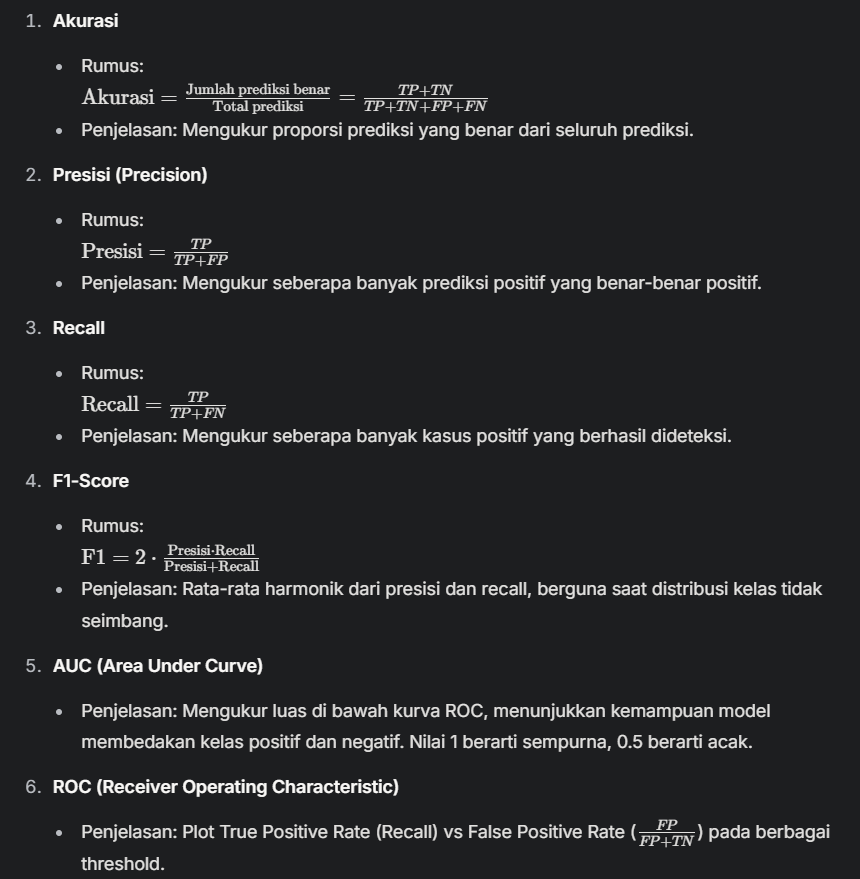